# Imports

In [1]:
import pandas as pd
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor
import torch
import datetime
from sklearn import metrics
import matplotlib.pyplot as plt

/Users/radu/Desktop/COMP0087/SentStock/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Data loading and cleaning

In [2]:
df = pd.read_csv('raw_analyst_ratings.csv')
df

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A
...,...,...,...,...,...,...
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 00:00:00,ZX
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 00:00:00,ZX
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 00:00:00,ZX
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 00:00:00,ZX


In [3]:
# change dates to the same format and timezone

df['date'] = pd.to_datetime(df['date'], format="ISO8601", utc=True)
df['date']

0         2020-06-05 14:30:54+00:00
1         2020-06-03 14:45:20+00:00
2         2020-05-26 08:30:07+00:00
3         2020-05-22 16:45:06+00:00
4         2020-05-22 15:38:59+00:00
                     ...           
1407323   2011-08-29 00:00:00+00:00
1407324   2011-06-22 00:00:00+00:00
1407325   2011-06-21 00:00:00+00:00
1407326   2011-06-21 00:00:00+00:00
1407327   2011-05-12 00:00:00+00:00
Name: date, Length: 1407328, dtype: datetime64[ns, UTC]

In [4]:
# select stocks
ticker = 'AAPL'

df = df[df['stock'] == ticker]
df

,Unnamed: 0,headline,url,publisher,date,stock
6680,7120,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10 15:33:26+00:00,AAPL
6681,7121,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10 12:14:08+00:00,AAPL
6682,7122,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10 11:53:47+00:00,AAPL
6683,7123,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10 11:19:25+00:00,AAPL
6684,7124,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10 10:27:11+00:00,AAPL
...,...,...,...,...,...,...
7116,7585,"UBS Maintains Buy on Apple, Lowers Price Targe...",https://www.benzinga.com/news/20/03/15514989/u...,Vick Meyer,2020-03-10 00:00:00+00:00,AAPL
7117,7586,123 Biggest Movers From Yesterday,https://www.benzinga.com/news/20/03/15514298/1...,Lisa Levin,2020-03-10 00:00:00+00:00,AAPL
7118,7587,Crude Awakening: Energy Sector Takes A 20% Spi...,https://www.benzinga.com/news/earnings/20/03/1...,JJ Kinahan,2020-03-09 00:00:00+00:00,AAPL
7119,7588,Investor Movement Index Summary: February 2020,https://www.benzinga.com/news/earnings/20/03/1...,TD Ameritrade,2020-03-09 00:00:00+00:00,AAPL


In [5]:
# reset indices

df = df.drop(columns=['Unnamed: 0']).reset_index(drop=True)
df

,headline,url,publisher,date,stock
0,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10 15:33:26+00:00,AAPL
1,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10 12:14:08+00:00,AAPL
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10 11:53:47+00:00,AAPL
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10 11:19:25+00:00,AAPL
4,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10 10:27:11+00:00,AAPL
...,...,...,...,...,...
436,"UBS Maintains Buy on Apple, Lowers Price Targe...",https://www.benzinga.com/news/20/03/15514989/u...,Vick Meyer,2020-03-10 00:00:00+00:00,AAPL
437,123 Biggest Movers From Yesterday,https://www.benzinga.com/news/20/03/15514298/1...,Lisa Levin,2020-03-10 00:00:00+00:00,AAPL
438,Crude Awakening: Energy Sector Takes A 20% Spi...,https://www.benzinga.com/news/earnings/20/03/1...,JJ Kinahan,2020-03-09 00:00:00+00:00,AAPL
439,Investor Movement Index Summary: February 2020,https://www.benzinga.com/news/earnings/20/03/1...,TD Ameritrade,2020-03-09 00:00:00+00:00,AAPL


# Load stock prices

In [6]:
# start date is 7 days before the earliest day from the df
# to make sure at least one trading day before is included
# (there might be weekend days/holidays etc.)

start_date = df['date'].min() - datetime.timedelta(7)
end_date = df['date'].max() + datetime.timedelta(7)

prices = yf.download('AAPL', start_date, end_date)

prices.index = pd.to_datetime(prices.index, format='%Y-%m-%d', utc=True)
prices

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02 00:00:00+00:00,70.570000,75.360001,69.430000,74.702499,72.950279,341397200
2020-03-03 00:00:00+00:00,75.917503,76.000000,71.449997,72.330002,70.633453,319475600
2020-03-04 00:00:00+00:00,74.110001,75.849998,73.282501,75.684998,73.909737,219178400
2020-03-05 00:00:00+00:00,73.879997,74.887497,72.852501,73.230003,71.512337,187572800
2020-03-06 00:00:00+00:00,70.500000,72.705002,70.307503,72.257500,70.562645,226176800
...,...,...,...,...,...,...
2020-06-11 00:00:00+00:00,87.327499,87.764999,83.870003,83.974998,82.227287,201662400
2020-06-12 00:00:00+00:00,86.180000,86.949997,83.555000,84.699997,82.937195,200146000
2020-06-15 00:00:00+00:00,83.312500,86.419998,83.144997,85.747498,83.962891,138808800


# Sentiment Analysis

In [7]:
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def sentiment_score(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits[0].detach().numpy()
    scores = softmax(scores)
    return scores


def fetch_sentiments_for_dataframe(df, model, tokenizer):
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(sentiment_score, row['headline']) for index, row in df.iterrows()]
        sentiments = [future.result() for future in futures]
    return sentiments


df['sentiment_scores'] = fetch_sentiments_for_dataframe(df, model, tokenizer)
df

/Users/radu/Desktop/COMP0087/SentStock/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,headline,url,publisher,date,stock,sentiment_scores
0,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10 15:33:26+00:00,AAPL,"[0.86588836, 0.047733624, 0.086378]"
1,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10 12:14:08+00:00,AAPL,"[0.03546891, 0.15026225, 0.8142688]"
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10 11:53:47+00:00,AAPL,"[0.051103264, 0.0149868205, 0.93390995]"
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10 11:19:25+00:00,AAPL,"[0.7484011, 0.03106585, 0.220533]"
4,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10 10:27:11+00:00,AAPL,"[0.03977929, 0.016892968, 0.9433277]"
...,...,...,...,...,...,...
436,"UBS Maintains Buy on Apple, Lowers Price Targe...",https://www.benzinga.com/news/20/03/15514989/u...,Vick Meyer,2020-03-10 00:00:00+00:00,AAPL,"[0.25266373, 0.35204548, 0.3952908]"
437,123 Biggest Movers From Yesterday,https://www.benzinga.com/news/20/03/15514298/1...,Lisa Levin,2020-03-10 00:00:00+00:00,AAPL,"[0.10599324, 0.02489496, 0.8691118]"
438,Crude Awakening: Energy Sector Takes A 20% Spi...,https://www.benzinga.com/news/earnings/20/03/1...,JJ Kinahan,2020-03-09 00:00:00+00:00,AAPL,"[0.022983856, 0.94826436, 0.028751735]"
439,Investor Movement Index Summary: February 2020,https://www.benzinga.com/news/earnings/20/03/1...,TD Ameritrade,2020-03-09 00:00:00+00:00,AAPL,"[0.027476706, 0.053617332, 0.918906]"


# Calculate trends and predicted trends

In [8]:
def trend(date):
  # trends are calculated using the close price from the previous trading day
  # and the open price of the next trading day to include the moment when the
  # news was made public (during or outside the trading hours)
  prev_date = prices[prices.index < date].index.max()
  prev_date_index = prices.index.get_loc(prev_date.strftime('%Y-%m-%d'))

  if date.strftime('%Y-%m-%d') == prev_date.strftime('%Y-%m-%d'):
    prev_date_index -= 1

  next_date = prices[prices.index > date].index.min()
  next_date_index = prices.index.get_loc(next_date.strftime('%Y-%m-%d'))
  ret = ((prices['Open'][next_date_index] - prices['Close'][prev_date_index]) / prices['Close'][prev_date_index]) * 100

  return_threshold = 3.0 # (3%)
  if ret >= return_threshold:
    return 'increase'
  elif ret <= -return_threshold:
    return 'decrease'
  else:
    return 'stable'


df['trend'] = df['date'].apply(trend)



def predicted_trend(sentiment_score):
  sentiment_threshold = 0.8 # (80%)
  if sentiment_score[0] >= sentiment_threshold:
    return 'increase'
  elif sentiment_score[1] >= sentiment_threshold:
    return 'decrease'
  else:
    return 'stable'


df['predicted_trend'] = df['sentiment_scores'].apply(predicted_trend)
df

,headline,url,publisher,date,stock,sentiment_scores,trend,predicted_trend
0,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10 15:33:26+00:00,AAPL,"[0.86588836, 0.047733624, 0.086378]",stable,increase
1,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10 12:14:08+00:00,AAPL,"[0.03546891, 0.15026225, 0.8142688]",stable,stable
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10 11:53:47+00:00,AAPL,"[0.051103264, 0.0149868205, 0.93390995]",stable,stable
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10 11:19:25+00:00,AAPL,"[0.7484011, 0.03106585, 0.220533]",stable,stable
4,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10 10:27:11+00:00,AAPL,"[0.03977929, 0.016892968, 0.9433277]",stable,stable
...,...,...,...,...,...,...,...,...
436,"UBS Maintains Buy on Apple, Lowers Price Targe...",https://www.benzinga.com/news/20/03/15514989/u...,Vick Meyer,2020-03-10 00:00:00+00:00,AAPL,"[0.25266373, 0.35204548, 0.3952908]",increase,stable
437,123 Biggest Movers From Yesterday,https://www.benzinga.com/news/20/03/15514298/1...,Lisa Levin,2020-03-10 00:00:00+00:00,AAPL,"[0.10599324, 0.02489496, 0.8691118]",increase,stable
438,Crude Awakening: Energy Sector Takes A 20% Spi...,https://www.benzinga.com/news/earnings/20/03/1...,JJ Kinahan,2020-03-09 00:00:00+00:00,AAPL,"[0.022983856, 0.94826436, 0.028751735]",decrease,decrease
439,Investor Movement Index Summary: February 2020,https://www.benzinga.com/news/earnings/20/03/1...,TD Ameritrade,2020-03-09 00:00:00+00:00,AAPL,"[0.027476706, 0.053617332, 0.918906]",decrease,stable


# Results

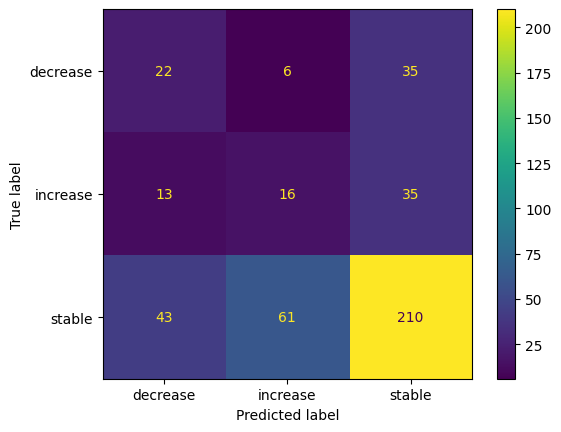

In [9]:
confusion_matrix = metrics.confusion_matrix(df['trend'], df['predicted_trend'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['decrease', 'increase', 'stable'])

cm_display.plot()
plt.show()